In [1]:
from fastai.vision.all import *
from SiamImage import *

In [2]:
base_path = Path('src')

img_train = base_path / 'train_images'
img_test = base_path / 'test_images'

In [3]:
df_train = pd.read_csv(base_path / 'train.csv')
df_test = pd.read_csv(base_path / 'test.csv')

Add the path to the image-file.

In [4]:
df_train['image'] = df_train['image'].apply(lambda x: img_train / x)

In [5]:
print(f'Unique images: {df_train.image_phash.nunique()} of {df_train.image.nunique()} unique image-files.')

Unique images: 28735 of 32412 unique image-files.


Drop duplicate image_phash.

In [6]:
df_train.drop_duplicates(['image_phash'], inplace = True)

In [7]:
df_groupby_label = df_train.groupby(['label_group'])['image_phash'].nunique().to_frame()

In [8]:
print(f'Number of labels, that contain only one image_phash: {(df_groupby_label.image_phash < 2).sum()}')

Number of labels, that contain only one image_phash: 1039


Only keep instances that belong to a label_group that contains more than one image_phash.

In [9]:
keep_labels = df_groupby_label[df_groupby_label.image_phash >= 2].index.tolist()
df_train = df_train[df_train['label_group'].isin(keep_labels)].reset_index(drop = True)

In [10]:
# Sanity check:
print(f"Number of labels, that contain only one image_phash: {(df_train.groupby(['label_group'])['image_phash'].nunique() < 2).sum()}")
print(f"Number of duplicate files: {df_train.duplicated(['image']).sum()}")

Number of labels, that contain only one image_phash: 0
Number of duplicate files: 0


We can now make shure to draw image-files with different phashes, when creating the Siamese dataset.

## create smaller dataset

In [11]:
small_pct = 0.1

In [12]:
x = df_train['label_group'].unique()
y = np.random.choice(x, size = int(len(x)*small_pct), replace = False)
df_train = df_train[df_train['label_group'].isin(y)]
df_train = df_train.reset_index(drop = True)

In [13]:
df_train.head()

,posting_id,image,image_phash,title,label_group
0,train_2238403912,src/train_images/003524b70715bf6bfa00451ca08e66e0.jpg,ba35c44a3fb7c068,Kangaroo Teflon / Allu Fry Pan 18 cm - KG652,531768918
1,train_1180155871,src/train_images/00369839c7d94411e54437b7cf59b603.jpg,bbc1c43ec3633ec0,[INCLUDE PAJAK] NCT DREAM RELOAD ALBUM,2224428568
2,train_1872347548,src/train_images/003906c6c6bba4cde15e5e854dba8f6d.jpg,f3e18c5ea14493e3,Stand Hanger Multifungsi - Tiang Gantungan Baju Jaket Syal 9 Hook,4044205497
3,train_1449570166,src/train_images/004ede0e328d05780813f853857463f1.jpg,c1d43c3f1f949685,Citra Tone Up Pearly White Body Lotion 180 ml / 180ml,3578753118
4,train_1640409557,src/train_images/0052b0b2e8233836f2875a14a9808b92.jpg,f4ad43c58e52b932,CHIL KID GOLD VANILA 800GR,1632207687


In [14]:
def split_by_label(df):
    # L-list of unique labels
    labels = L(df.label_group.unique().tolist())
    # Randomly split labels
    split_labels = RandomSplitter(valid_pct=0.2)(labels)  # Returns 80/20 split of labels

    # Mask labels to receive train/val labels
    train_labels = labels[split_labels[0]]
    validation_labels = labels[split_labels[1]]

    # Add colum to mark file as a part of the training/validation set
    df['is_valid'] = df_train.label_group.isin(validation_labels)

    # Sanity check:
    assert((df.groupby(['label_group'])['is_valid'].nunique() > 1).sum() == 0)
    
    files = L(df['image'].tolist())
    train_idx = df[df['is_valid'] == False].index.tolist()
    validation_idx = df[df['is_valid'] == True].index.tolist()
    
    # Sanity check:
    assert(set(files[train_idx]) == set(df[df['is_valid'] == False]['image']))
    assert(set(files[validation_idx]) == set (df[df['is_valid'] == True]['image']))
    
    return files, train_labels, validation_labels, train_idx, validation_idx

In [15]:
files, train_labels, validation_labels, train_split, val_split = split_by_label(df_train)
splits = (train_split, val_split)
labels = (train_labels,validation_labels)

In [16]:
splits_files = [files[splits[i]] for i in range(2)]
splits_sets = mapped(set, splits_files)

In [17]:
splbl2files = [(df_train.loc[splits[i]]).groupby(['label_group'])['image'].apply(list).to_dict() for i in range(2)]

<AxesSubplot:title={'center':'False'}>

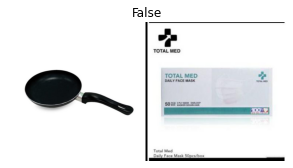

In [18]:
img1 = PILImage.create(files[0])
img2 = PILImage.create(files[154])
s = SiameseImage(img1, img2, False)
s.show()

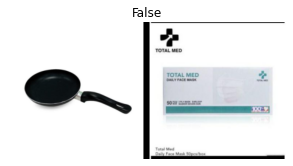

In [19]:
tst = Resize(224)(s)
tst = ToTensor()(tst)
tst.show();

In [20]:
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits = splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],
                      bs = 8
                     )

NameError: name 'df_train' is not defined

In [ ]:
dls.show_batch()

In [ ]:
encoder = create_body(resnet34, cut=-2)

In [ ]:
head = create_head(512*2, 2, ps=0.5)
model = SiameseModel(encoder, head)

In [ ]:
learn = Learner(dls,
                model,
                #loss_func = loss_func,
                loss_func = CrossEntropyLossFlat(),
                splitter = siamese_splitter,
                metrics = accuracy
               )

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(7, 3e-3)

In [ ]:
learn.save('full_df_224_frozen_7epos')

In [ ]:
learn.load('full_df_224_frozen_7epos')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, slice(5e-7,1e-4))

In [ ]:
@typedispatch
def show_results(x:SiameseImage, 
                 y, 
                 samples, 
                 outs, 
                 ctxs=None, 
                 max_n=6, 
                 nrows=None, 
                 ncols=2, 
                 figsize=None, 
                 **kwargs                
                ):
    if figsize is None: 
        figsize = (ncols*6, max_n//ncols * 3)
        
    if ctxs is None: 
        ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
        
    for i,ctx in enumerate(ctxs):
        title = f'Actual: {["Not similar","Similar"][int(x[2][i].item())]} \n Prediction: {["Not similar","Similar"][y[2][i].argmax().item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

In [ ]:
learn.show_results()

In [ ]:
preds = learn.get_preds()

In [ ]:
print(type(preds[1]))

In [ ]:
len(preds[1]), preds[1].sum()

In [ ]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    if res[0] == tensor(0):
        SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
    else:
        SiameseImage(item[0], item[1], 'Prediction: Similar').show()
    return res

In [ ]:
imgtest = PILImage.create(files[0])
imgval = PILImage.create(files[100])
siamtest = SiameseImage(imgval, imgtest)
siamtest.show();

In [ ]:
res = learn.siampredict(siamtest)